# CIFAR-10 classification

In First part of this project, a simple feed forward fully connected nueral network is implemented to classify first four classes of this dataset.  
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 
This Prroject has 5 major parts:  
 1. Loading dataset
 2. Feedforward implementation
 3. Backpropagation (non-vectorized and with loops)
 4. Backpropagation (vectorized form)
 5. Test final model  
  
For training the network Stochastic Gradient Descent was used, implemented in tow forms of iterative backpropagation and vectorized backpropagation. 

## Step1:
###  Load and prepare Dataset

In [1]:
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g
To: /content/CIFAR10.tar.gz
100% 19.8M/19.8M [00:00<00:00, 250MB/s]


### Data Visualization

In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
base_dir = './CIFAR10'

# Directories for our training, and test splits
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
labels = os.listdir(train_dir)

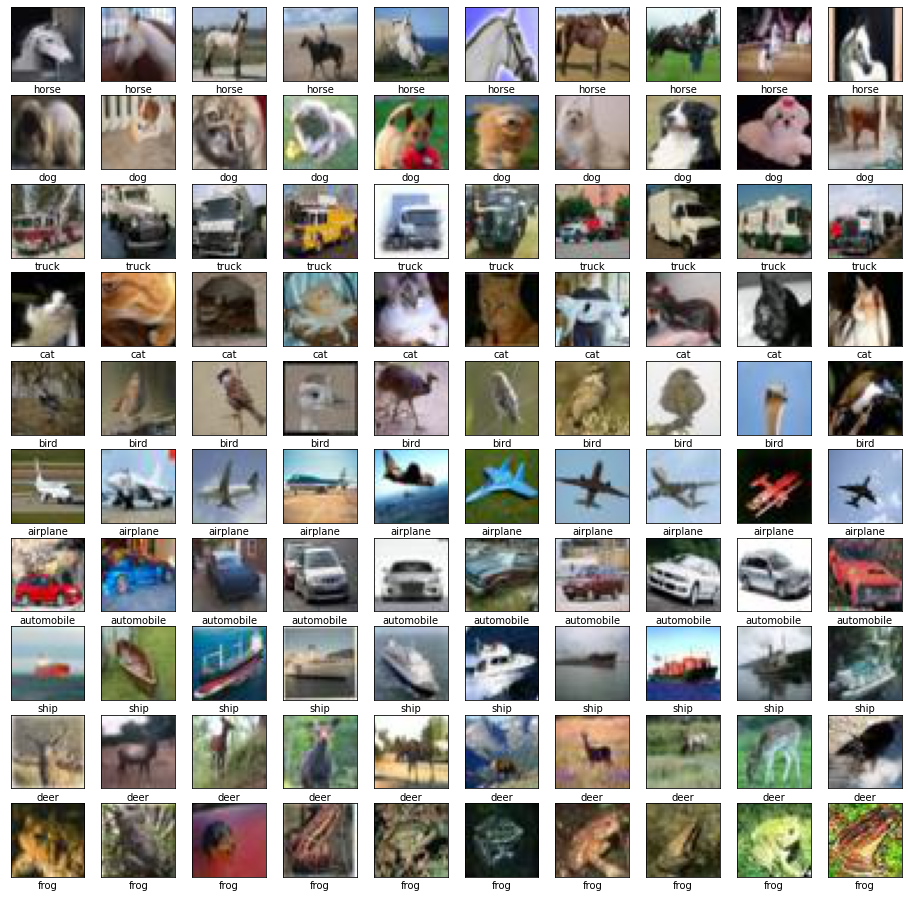

In [4]:
# Here we read data from folders and stored them as a numpy array
# After that we want to show 10 images from each class

sample_data = []
sample_labels = []
plt.figure(figsize=(16,16))
for label in labels:
    label_path = os.path.join(train_dir, label)
    j=0
    for image_name in os.listdir(label_path):
        if j>9:
            break
        image_path = os.path.join(label_path, image_name)
        data = np.array(plt.imread(image_path))
        sample_data.append(data)
        sample_labels.append(label)
        j+=1
# Now we can show them        
for i in range(len(sample_data)):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(sample_data[i], cmap=plt.cm.binary)
    plt.xlabel(sample_labels[i])


### Data preprocessing

In [5]:
# first four classes in dataset
labels[:4]

['horse', 'dog', 'truck', 'cat']

In [6]:
# Because we want to do classification task on first four classes we should separte them
x_train = []
y_train_original = []
x_test = []
y_test_original = []
for label in labels[:4]:
    label_path = os.path.join(train_dir, label)
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name)
        data = np.array(plt.imread(image_path))
        x_train.append(data)
        y_train_original.append(label)
for label in labels[:4]:
    label_path = os.path.join(test_dir, label)
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name)
        data = np.array(plt.imread(image_path))
        x_test.append(data)
        y_test_original.append(label)

Now we can see the the shape of x_test. it should be 4000, 32, 32, 3

In [7]:
np.shape(x_test)

(4000, 32, 32, 3)

####  1) one-hot on y_train_original and y_test_original

In [8]:
from sklearn import preprocessing

In [9]:
# create a LabelEncoder object and fit it to each feature in y_train_original and y_test_original
le = preprocessing.LabelEncoder()
y_train_encoded = le.fit_transform(y_train_original)
y_test_encoded = le.fit_transform(y_test_original)

In [10]:
# The first class get 0 as alabel and ... and fourth class get 3 as label
y_test_encoded

array([2, 2, 2, ..., 0, 0, 0])

In [11]:
# create a OneHotEncoder object, and fit it to all of y_train_encoded and y_test_encoded
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y_train = enc.fit_transform(y_train_encoded.reshape(-1, 1)).toarray()
y_test = enc.fit_transform(y_test_encoded.reshape(-1, 1)).toarray()

In [12]:
# After one-hot for y_test we should have 4000, 4 as a shape
np.shape(y_test)

(4000, 4)

#### 2) change images to graylevel

In [13]:
# This function get the rgb images as entry and covert them to gray scale
def rgb2gray(rgb):
    r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

In [14]:
x_train_gray = rgb2gray(np.array(x_train))
x_test_gray = rgb2gray(np.array(x_test))

In [15]:
# After converting to gray level we don`t have 3 channels for each image
np.shape(x_train_gray)

(20000, 32, 32)

#### 3) Normalization

In [16]:
# normalize our data values to the range [0, 1]
x_train_gray = x_train_gray.astype('float32')
x_test_gray = x_test_gray.astype('float32')
x_train_gray /= 255
x_test_gray /= 255

#### 4)Flatten the data

In [17]:
# Because we have fully connected network we should flatten the input data
x_train_gray = x_train_gray.reshape(-1, 1024)
x_test_gray = x_test_gray.reshape(-1, 1024)

In [18]:
# after above converting we have 2000 samples with size 1024(32*32=1024)
x_train_gray.shape

(20000, 1024)

#### 5)Shuffle data

In [19]:
# This function get data and its labels and shuffle them
# Also the permutation for x and y is the same
def shuffle(x, y):
    p = np.random.permutation(y.shape[0])
    return x[p], y[p]
x_train_gray, y_train = shuffle(x_train_gray, y_train)

### Implementing MLP class
#### This class is used in step2 to step5 (Feedforward and Backpropagation are inside this section, together)

First we define our activation function and its derivative. In this project our activation function is sigmoid

In [20]:
# sigmoid activation function
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# derivative of sigmoid activation function
def d_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [21]:
class MLP:
    
    """ Here we create the weights matrix and biases vector and initialize them. 
    We get layer_size as an entry in form of list[tuple[int, int]] """
    
    def __init__(self, layer_size):
        self.weights = []
        self.biases = []
        self.layers_number = len(layer_size)+1 # with considering input_layer
        self.layer_size = layer_size
        
        #initializing weights and biases
        #  - First layer is input layer and it doesn`t have Weight 
        #    or biase. we only consider it for simplify the operations in future.
        #    but we don`t use this layer weight or biase in calculations.
        self.weights.append(np.random.normal(size=(layer_size[0][1], layer_size[0][1])))
        self.biases.append(np.zeros(layer_size[0][1]))
        #  - For other layers(hidden and output) we have:
        #   for weights between two layer consider a K×n matrix 
        #   and k: neuron numbers of next layer and n:neuron numbers of current layer
        for size in layer_size:
            self.weights.append(np.random.normal(size=size))
            self.biases.append(np.zeros(size[0]))
        
    """ In feedforward function for calculating output according to entries
    we should calculate:
                a(L+1) = sigmoid_func(W(L+1)×a(L)+b(L+1))
    after all (a) contains the output of each layer"""
    
    def feedforward(self, data):
        W = self.weights
        b = self.biases
        a = []  #contain the output after activation function
        z = []  #contain the entry of activation function
        # First layer is input layer and its output is data
        a.append(data)
        z.append(0)
        # for other layers we have:
        for L in range(self.layers_number-1):
            Z = np.matmul(W[L+1], a[L]) + b[L+1]
            layer_output = sigmoid(Z)
            a.append(layer_output)
            z.append(Z)
        return a, z
    
    """ For trasining a MLP we need x_train and y_train and also some hyperparameters
    In this function we get batch_size and number_of_epochs and learning_rate
    as entry hyperparameters. They have default value 16, 10, 0.3.
    Backpropagation is performing here."""
    
    def train(self, x_train, y_train, batch_size=16, number_of_epochs=10, learning_rate=0.3, vectorized=False):
        W = self.weights
        b = self.biases
   
        # Performing learning algorithm
        avg_cost_values = []                                        #contains the average costs in each epoch
        for i in range(number_of_epochs):
            # Shuffle the train set
            x_train, y_train = shuffle(x_train, y_train)
            cost=0  
            for j in range(0, x_train.shape[0], batch_size):
                batch_of_x_train = x_train[j:j+batch_size, :]       # A batch of inputs
                batch_of_y_train = y_train[j:j+batch_size, :]       # A batch of outputs
                
                # Claculate th number of data in batch
                # we need this because its possible that last batch of data 
                # doesnt contain data as much as other
                m = batch_of_x_train.shape[0]
                if m == 0:
                    continue
                
                # Allocate grad_W matrix and grad_b vector for each layer and initialize to 0
                grad_W, grad_b,_ = self.grad_creator()
                
                for image, label in zip(batch_of_x_train, batch_of_y_train):
                    # Outputs of each layer for the given batch stored in a
                    # The Outputs of each layer before activation function stored in z
                    a, z = self.feedforward(image)
                    cost += self.cost_function(a[self.layers_number-1], label)
                    if vectorized:
                        grad_w_calculated, grad_b_calculated = self.vectorized_backpropagation(a,z,label,W)
                    else:
                        grad_w_calculated, grad_b_calculated = self.backpropagation(a,z,label,W)
                        
                    for k in range(self.layers_number):
                        grad_W[k] += grad_w_calculated[k]
                        grad_b[k] += grad_b_calculated[k] 
                        
                # Update values of Weight matrix and biase vector        
                for k in range(1,self.layers_number-1):
                    W[k] -= learning_rate * (1/m) * grad_W[k]               
                    b[k] -= learning_rate * (1/m) * grad_b[k]
            
            avg_cost_values.append(cost/len(x_train))
        return avg_cost_values
    
    
    """ This cost_function get the calculated y as y_output and the original y as y_target
    then according to cost function type it can calculate the cost value."""
    
    def cost_function(self, y_output, y_target, cost_function_type='SSE'):
        if cost_function_type == 'SSE':
            return (y_output - y_target).dot(y_output - y_target)
        
    """ This function create grad_W and grad_b and grad_a with a similar size to
    W, b, a matrix and vectors. also initialize them to 0 with np.zeros() function."""
    
    def grad_creator(self):
        grad_W = []
        grad_b = []
        grad_a = []
        # for input layer(it dosn`t have effect on calculation) we have:
        grad_W.append(np.zeros((self.layer_size[0][1], self.layer_size[0][1])))
        grad_b.append(np.zeros(self.layer_size[0][1]))
        grad_a.append(np.zeros(self.layer_size[0][1]))
        for size in self.layer_size:
            grad_W.append(np.zeros(size))
            grad_b.append(np.zeros(size[0]))
            grad_a.append(np.zeros(size[0]))
        return grad_W, grad_b, grad_a
    
    """ This backpropagation procedure is none vectorized. It run on each cell of
    grad matrixes and doesn`t optimum.
    it takes a nad z and W matrixes and label(target_y) as entries and give grad_a and
    grad_b as outputs"""
    
    def backpropagation(self,a,z,label,W):
        
        grad_W,grad_b,grad_a = self.grad_creator()
        
        last_i = self.layers_number-1      # last layer number
        
        # for last layer we have:
        # grad_w of last layer:
        for j in range(self.layer_size[last_i-1][0]):
            for k in range(self.layer_size[last_i-1][1]):
                grad_W[last_i][j, k] += a[last_i-1][k] * d_sigmoid(z[last_i][j]) * (2 * a[last_i][j]- 2 * label[j]) 
        # grad_b of last layer:
        for j in range(self.layer_size[last_i-1][0]):
            grad_b[last_i][j] += 1 * d_sigmoid(z[last_i][j]) * (2 * a[last_i][j]- 2 * label[j]) 
        # grad_a of last layer:
        for k in range(self.layer_size[last_i-1][1]):
            for j in range(self.layer_size[last_i-1][0]):
                grad_a[last_i-1][k] += W[last_i][j, k] * d_sigmoid(z[last_i][j]) * (2 * a[last_i][j]- 2 * label[j])
        
        # for other layers we have:
        # grad_a:
        for i in range(self.layers_number-2,1,-1):
            for j in range(self.layer_size[i-1][1]):
                for k in range(self.layer_size[i-1][0]):
                    grad_a[i-1][j] += W[i][k, j] * d_sigmoid(z[i][k]) * grad_a[i][k]
        # grad_w:
        for i in range(self.layers_number-2,0,-1):
            for j in range(self.layer_size[i-1][0]):
                for k in range(self.layer_size[i-1][1]):
                    grad_W[i][j, k] += a[i-1][k] * d_sigmoid(z[i][j]) * grad_a[i][j]
        # grad_b:
        for i in range(self.layers_number-2,0,-1):
            for j in range(self.layer_size[i-1][0]):
                grad_b[i][j] += 1 * d_sigmoid(z[i][j]) * grad_a[i][j]
        

        return grad_W,grad_b
    
    """ This backpropagation procedure is vectorized and is more optimal than non-vectorized
    Here we work with matrix and vector multiplication and alot of works can be done parallel"""
    
    def vectorized_backpropagation(self,a,z,label,W):
    
        grad_W,grad_b,grad_a = self.grad_creator()
        
        last_i = self.layers_number-1      # last layer number
        
        # for last layer we have:
        # grad_W:
        grad_W[last_i] += np.matrix((2 * d_sigmoid(z[last_i]) * (a[last_i] - label))).T @ np.matrix(a[last_i-1])
        # grad_b:
        grad_b[last_i] += (2 * d_sigmoid(z[last_i]) * (a[last_i] - label))
        # grad_a:
        grad_a[last_i-1] += np.transpose(W[last_i]) @ (2 * d_sigmoid(z[last_i]) * (a[last_i] - label))
        
        # for other layers we have:
        # grad_a:
        for i in range(self.layers_number-2,1,-1):
            grad_a[i-1] +=  W[i].T @ (d_sigmoid(z[i]) * grad_a[i])
        # grad_W , grad_b:
        for i in range(self.layers_number-2,0,-1):
            grad_W[i] += np.matrix(d_sigmoid(z[i]).T * grad_a[i]).T @ np.matrix(a[i-1])
            grad_b[i] += (d_sigmoid(z[i]) * grad_a[i])
        
        return grad_W, grad_b
    
    """ We can test the model with this function. it returns the accuracy of model."""
    
    def test(self, x, y):
        counter = 0
        for i in range(len(x)):
            a, z = self.feedforward(x[i])
            if np.argmax(a[3]) == np.argmax(y[i]):
                counter += 1
        accuracy = counter/len(x)
        return accuracy
    

## Step2:
### Feedforward phase

Code of this section is implemented in MLP class. the name of function is feedforward.  
We can calculate (a) in each layer with following formula:  

$$ a^{(L+1)} = \sigma{(W^{(L+1)}\times{a^{(L)}} + b^{(L+1)}) }$$  
Also we can test the network before training only with feedforward phase. We expect the average accuracy to be around 25% since weights are random and network is not trained yet.

In [22]:
# first we should create a MLP object
#   according to weights between two layer that we consider a K×n matrix 
#   and k: neuron numbers of next layer and n:neuron numbers of current layer
#   so we determine the layers size according to them.
mlp = MLP([(16, 1024), (16, 16), (4, 16)])

# with test function in MLP class we can find test model with given data and find accuracy
# Using 200 items of train data (we know we dont use them for training before:) )to see the accuracy for Phase 1
print('Accuracy before train:', mlp.test(x_train_gray[:200, :], y_train[:200, :])*100, '%')

Accuracy before train: 26.0 %


## Step3:
### non-vectorized Backpropagation

For training the model we have an algorithm like what we have in project explanation. So first we should implement the Psudo code below:  


<div>
<img src="pics/psudocode.png" width="600"/>
</div>


In MLP class this algorithm is implemented. In non-vectorixed backpropagation we should calculate grad matrixes with for loops. In MLP class, with backpropagation function we do this job.  
We used SSE cost-function. the formula is:  
$$ Cost = \sum_{j = 0}^{n_L -1 }{{(a_j^{(L)} - y_j)}^2 }$$  

We want to minimum the cost. We can use Gradient Descent for this. we should calculate partial derivatives of the Cost function with respect to other parameters. for calculating partial derivatives we can use chain rule. according to chane rule we have:  
$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(L)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial w_{jk}^{(L)}} $$  
$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(L)}} = \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial b_{j}^{(L)}} $$  
If we simpilify we can have the below formulas. Also we need derivative according to Activations and they calculated like others.

### (Last layer):
#### Derivative according to Weights:
$$\displaystyle \frac{\partial Cost}{\partial w_{jk}^{(L)}} = 2(a_{j}^{(L)} - y_{j}) \times \sigma^{'}(z_{j}^{(L)})\times a_{k}^{(L-1)}$$
#### Derivative according to Biases:
$$\displaystyle \frac{\partial Cost}{\partial b_{j}^{(L)}} = 2(a_{j}^{(L)} - y_{j}) \times \sigma^{'}(z_{j}^{(L)})\times 1$$
#### Derivative according to Activations:
$$\displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} = \sum_{j=0}^{n_{(L-1)}} \displaystyle \frac{\partial Cost}{\partial a_{j}^{(L)}} \times \displaystyle \frac{\partial a_{j}^{(L)}}{\partial z_{j}^{(L)}} \times \displaystyle \frac{\partial z_{j}^{(L)}}{\partial a_{k}^{(L-1)}} $$  
### (Other layers):
#### Derivative according to Weights:  
$$\displaystyle \frac{\partial Cost}{\partial w_{km}^{(L-1)}} =  \displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times a_{m}^{(L-2)}$$
#### Derivative according to Biases:  
$$\displaystyle \frac{\partial Cost}{\partial b_{k}^{(L-1)}} = \displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times 1$$
#### Derivative according to Activations:  
$$\displaystyle \frac{\partial Cost}{\partial a_{m}^{(L-2)}} = \sum_{k=0}^{n_{(L-2)}} (\displaystyle \frac{\partial Cost}{\partial a_{k}^{(L-1)}} \times \sigma^{'}(z_{k}^{(L-1)})\times w_{km}^{(L-1)}) $$  
The above formula is implemented in **backpropagation function in MLP class**.

Training finished within :  371.5527584552765 s


Text(0, 0.5, 'Cost')

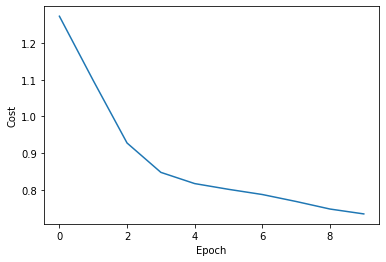

In [23]:
import time
# first we define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs=10

# list of average costs in each epoch
costs = []
# Using 200 items of train data for Training the model
x = x_train_gray[:200, :]
y = y_train[:200, :]

# Also We measure time of training
start = time.time()
costs = mlp.train(x, y, batch_size=batch_size, number_of_epochs=number_of_epochs, learning_rate=learning_rate)
end = time.time()
print('Training finished within : ', end - start, 's')

# plot costs in each epoch
plt.plot(range(number_of_epochs), costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")


Now we can calculate accuracy on train and test(unseen data). According to project explanation we expect to have accuracy near 30% on 200 train data

In [24]:
print("accuracy after training, on train data: " , mlp.test(x, y)*100 , " %")
print("accuracy after training, on test data: " , mlp.test(x_test_gray, y_test)*100 , " %")

accuracy after training, on train data:  39.5  %
accuracy after training, on test data:  31.724999999999998  %


Our runtime is near 350 s. we can increase number of epochs to 15. it shows that our accuracy on train data is become better a little.

Text(0, 0.5, 'Cost')

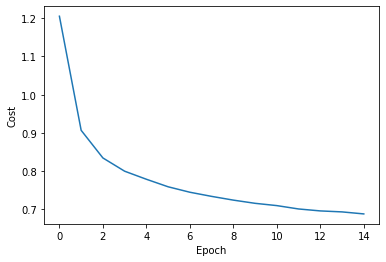

In [25]:
mlp_feedforward2 = MLP([(16, 1024), (16, 16), (4, 16)])
# first we define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs=15

# list of average costs in each epoch
costs = []
# Using 200 items of train data for Training the model
x = x_train_gray[:200, :]
y = y_train[:200, :]

# train model
costs = mlp_feedforward2.train(x, y, batch_size=batch_size, number_of_epochs=number_of_epochs, learning_rate=learning_rate)

# plot costs in each epoch
plt.plot(range(number_of_epochs), costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")

In [26]:
print("accuracy after training, on train data: " , mlp_feedforward2.test(x, y)*100 , " %")
print("accuracy after training, on test data: " , mlp_feedforward2.test(x_test_gray, y_test)*100 , " %")

accuracy after training, on train data:  43.0  %
accuracy after training, on test data:  31.1  %


## Step4:
### Vectorized Backpropagation

Code of this section is implemented in **vectorized_backpropagation in MLP class**. we dont use for loop for calculates derivatives with respect to each element of vector or matrix. we can use matrix multiplications. also for doing this we get help from project explanation and codes like this:  
grad_w3 += (2 * sigmoid_deriv(z3) * (a3 - y)) @ (np.transpose(a2))


Training finished within :  9.963163137435913 s


Text(0, 0.5, 'Cost')

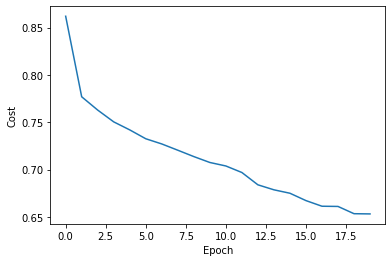

In [27]:
# first we define new mlp with same layers like before
mlp2 = MLP([(16, 1024), (16, 16), (4, 16)])

# define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs=20

# list of average costs in each epoch
costs = []

# Using 200 items of train data for Training the model
x = x_train_gray[:200, :]
y = y_train[:200, :]

# Training the model
start = time.time()
costs = mlp2.train(x, y, batch_size=batch_size, number_of_epochs=number_of_epochs, learning_rate=learning_rate,vectorized=True)
end = time.time()
print('Training finished within : ', end - start, 's')

# plot costs in each epoch
plt.plot(range(number_of_epochs), costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")

Now we can calculate accuracy on train and test(unseen data). According to project explanation we expect to have accuracy near 30% on 200 train data

In [28]:
print("accuracy after training, on train data: " , mlp2.test(x, y)*100 , " %")
print("accuracy after training, on test data: " , mlp2.test(x_test_gray, y_test)*100 , " %")

accuracy after training, on train data:  53.5  %
accuracy after training, on test data:  32.9  %


#### Conclusion:
According to measured times, time is decreased very much because vectorised used parallel work

### Training network for 10  iterations:

beacuse we should show results in next step like this step so its better to define some functions 

In [29]:
""" This function get model and data and hyperparameters and number of iteartions and vectorized boolean variable
And then train model number_of_iterations time.
It returns train_accuracy, test_accuracy,  costs of epochs for each iteration"""

def train_iteration(model, data, hyperparameters, number_of_iterations, vectorized):
    x_train, y_train, x_test, y_test = data
    batch_size, nuber_of_epochs, learning_rate = hyperparameters
    
    train_accuracy = []
    test_accuracy = []
    cost = []
    for i in range(number_of_iterations):
        # train model
        costs_of_epoch = model.train(x_train, y_train, batch_size, number_of_epochs, learning_rate, vectorized)
        # test the model and find accuracy and append to related list for each iteration
        train_accuracy.append(model.test(x_train, y_train)*100)
        test_accuracy.append(model.test(x_test, y_test)*100)
        # append the cost_of_epochs list to cost list for each iteration
        cost.append(costs_of_epoch)
    
    return train_accuracy, test_accuracy, cost

""" This function plot accuracy of train and test per itertion"""

def plot_accuracy_iteration(train_accuracy, test_accuracy):
    fig, axs = plt.subplots(1,2, sharex=False, sharey=True, figsize=(15,5))
    axs[0].plot(train_accuracy)
    axs[0].set(xlabel='Iteration', ylabel='Accuracy')
    axs[0].set_title('train accuracy')
    axs[1].plot(test_accuracy)
    axs[1].set(xlabel='Iteration', ylabel='Accuracy')
    axs[1].set_title('test accuracy')
    fig.tight_layout()

""" This """
def plot_costs_iteration(cost, number_of_iterations):
    # we can have five plot in each row
    number_of_row = number_of_iterations // 5
    fig, axs = plt.subplots(number_of_row, 5, sharex=True, sharey=True, figsize=(12,7))
    for row in range(number_of_row):
        for column in range(5):
            axs[row, column].plot(cost[column+row*5])
            axs[row, column].set(xlabel='epoch', ylabel='cost')
            axs[row, column].set_title(f'Iteration {1+column+row*5}')
            axs[row, column].label_outer()  
    fig.tight_layout()

The mean accuracy on train data is: 65.3 %
The mean accuracy on test data is: 36.68750000000001 %
The plots of train and test accuracy and costs-epochs in each iteratio:


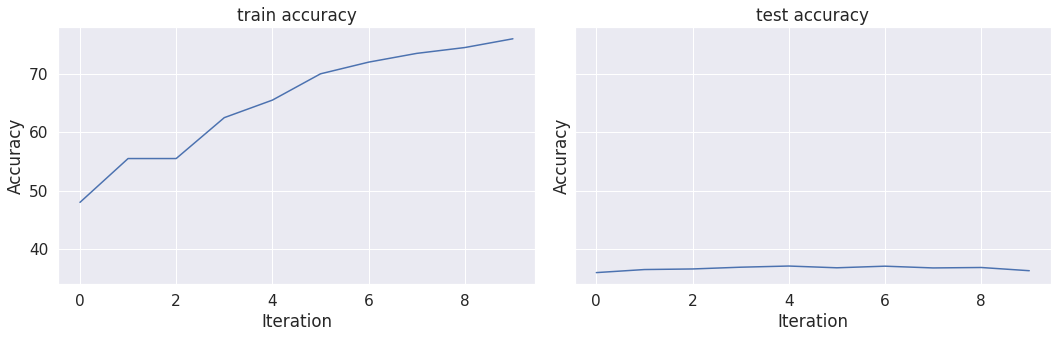

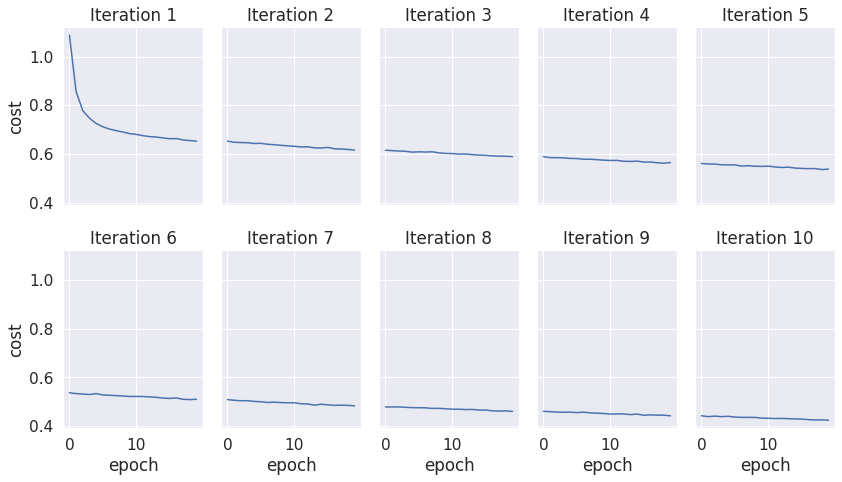

In [142]:
# first we define new mlp with same layers like before
mlp3 = MLP([(16, 1024), (16, 16), (4, 16)])

# define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 20
hyperparameters = (batch_size, number_of_epochs, learning_rate)

# Using 200 items of train data for Training the model
x_tr = x_train_gray[:200, :]
y_tr = y_train[:200, :]
x_te = x_test_gray
y_te = y_test
data = (x_tr, y_tr, x_te, y_te)

# training for 10 iterations
train_accuracy=[]
test_accuracy=[]
cost=[]
train_accuracy, test_accuracy, cost = train_iteration(mlp3, data, hyperparameters, number_of_iterations=10, vectorized=True)
print("The mean accuracy on train data is:", sum(train_accuracy)/len(train_accuracy), "%")
print("The mean accuracy on test data is:", sum(test_accuracy)/len(test_accuracy), "%")

#plot
print("The plots of train and test accuracy and costs-epochs in each iteratio:")
plot_accuracy_iteration(train_accuracy, test_accuracy)
plot_costs_iteration(cost, number_of_iterations=10)

## Step 5:
### Test the model

#### Train one time
First We train the model with vectorized version on 8000 data and only one time

Text(0, 0.5, 'Cost')

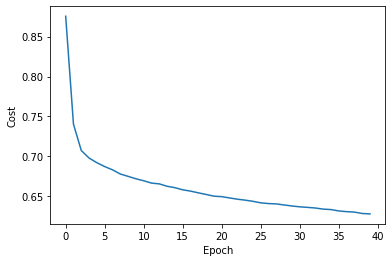

In [31]:
# first we define new mlp with same layers like before
mlp4 = MLP([(16, 1024), (16, 16), (4, 16)])

# define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 40

# list of average costs in each epoch
costs = []

# Using 8000 items of train data for Training the model
x = x_train_gray[:8000, :]
y = y_train[:8000, :]

# Training the model
costs = mlp4.train(x, y, batch_size=batch_size, number_of_epochs=number_of_epochs, learning_rate=learning_rate,vectorized=True)

# plot costs in each epoch
plt.plot(range(number_of_epochs), costs)
plt.xlabel("Epoch")
plt.ylabel("Cost")

We should get to accuracy near 50 % according to project explanation

In [32]:
print("accuracy after training, on train data: " , mlp4.test(x, y)*100 , " %")
print("accuracy after training, on test data: " , mlp4.test(x_test_gray, y_test)*100 , " %")

accuracy after training, on train data:  49.512499999999996  %
accuracy after training, on test data:  46.85  %


#### Train 10 times

The mean accuracy on train data is: 58.9625 %
The mean accuracy on test data is: 47.86749999999999 %
The plots of train and test accuracy:
The plots of costs-epochs in each iteration:


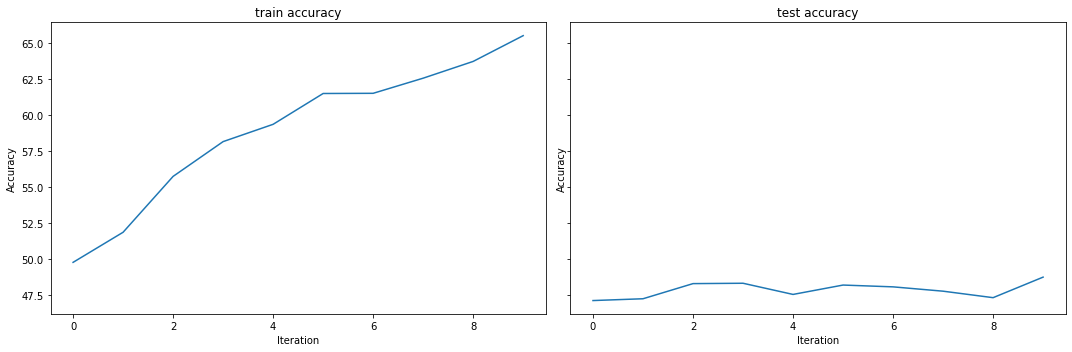

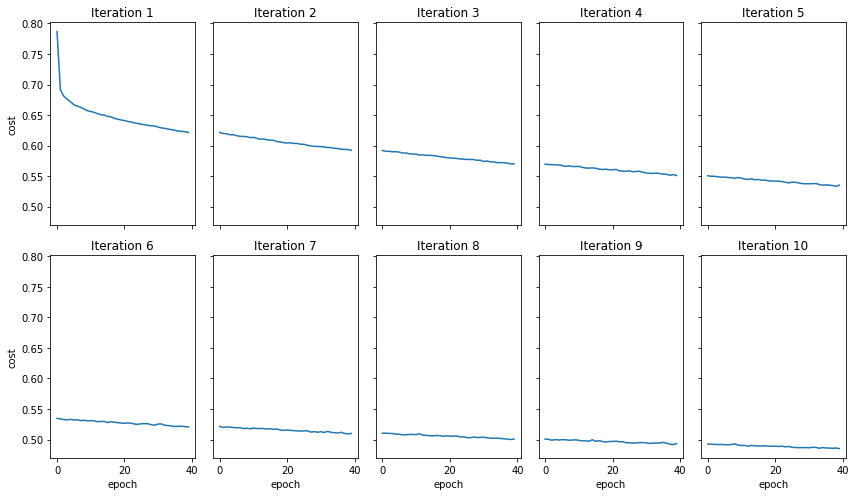

In [33]:
# first we define new mlp with same layers like before
mlp5 = MLP([(16, 1024), (16, 16), (4, 16)])

# define hyperparameters:
batch_size = 16
learning_rate = 0.3
number_of_epochs = 40
hyperparameters = (batch_size, number_of_epochs, learning_rate)

# Using 8000 items of train data for Training the model
x_tr = x_train_gray[:8000, :]
y_tr = y_train[:8000, :]
x_te = x_test_gray
y_te = y_test
data = (x_tr, y_tr, x_te, y_te)

# training for 10 iterations
train_accuracy=[]
test_accuracy=[]
cost=[]
train_accuracy, test_accuracy, cost = train_iteration(mlp5, data, hyperparameters, number_of_iterations=10, vectorized=True)
print("The mean accuracy on train data is:", sum(train_accuracy)/len(train_accuracy), "%")
print("The mean accuracy on test data is:", sum(test_accuracy)/len(test_accuracy), "%")

#plot
print("The plots of train and test accuracy:")
plot_accuracy_iteration(train_accuracy, test_accuracy)
print("The plots of costs-epochs in each iteration:")
plot_costs_iteration(cost, number_of_iterations=10)

## Additional Part

Complete explanation about Additional part is added to a pdf file

### Section 1

In [48]:
# first we import the libraries that we need
from tensorflow import keras
from tensorflow.keras import datasets, layers, losses
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix

In [49]:
#Load Dataset
(x_train2, y_train2), (x_test2, y_test2) = keras.datasets.cifar10.load_data()

In [50]:
# Normalize data between 0 and 1
x_train2, x_test2 = x_train2/255.0, x_test2/255.0

In [51]:
# Now we can see the shape of x_train array
print(type(x_train2))
print(x_train2.shape)

<class 'numpy.ndarray'>
(50000, 32, 32, 3)


In [52]:
# The name of classe in order are:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

### Question 1

according to architecture, we have same padding because the size of input remain same. first we have 32 numbers 3*3 kernel.
The out put of Maxpool is 16*16 so we should use 2*2 maxpooling. with respect to below architectur and the explanation we can create the model.

<div>
<img src="pics/architectur.png" width="600"/>
</div>


In [53]:
# The simple model according to image is:
model_q1 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.MaxPool2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [54]:
# We can show the created model
model_q1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 conv2d_11 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

In [55]:
# We set optimizer adam as what said in educational video
# Because we have classification task we should use crossentropy as Loss
model_q1.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [56]:
# Now we should fit model on train data
history_q1 = model_q1.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.6058 - accuracy: 0.3976 - val_loss: 1.2860 - val_accuracy: 0.5307
Epoch 2/25
1563/1563 [==============================] - 30s 19ms/step - loss: 1.0552 - accuracy: 0.6231 - val_loss: 0.9972 - val_accuracy: 0.6544
Epoch 3/25
1563/1563 [==============================] - 29s 19ms/step - loss: 0.8459 - accuracy: 0.7035 - val_loss: 0.8838 - val_accuracy: 0.6911
Epoch 4/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.7071 - accuracy: 0.7553 - val_loss: 0.7918 - val_accuracy: 0.7359
Epoch 5/25
1563/1563 [==============================] - 29s 19ms/step - loss: 0.6112 - accuracy: 0.7874 - val_loss: 0.7847 - val_accuracy: 0.7376
Epoch 6/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.5380 - accuracy: 0.8144 - val_loss: 0.7478 - val_accuracy: 0.7536
Epoch 7/25
1563/1563 [==============================] - 30s 19ms/step - loss: 0.4794 - accuracy: 0.8349 - val_loss: 0.7635 -

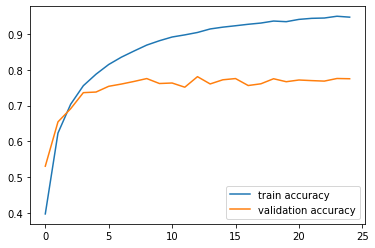

In [58]:
# Plot train and validation accuracy
plt.plot(history_q1.history['accuracy'], label='train accuracy')
plt.plot(history_q1.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

According to plots overfitting is occured and our validation accuracy doesn`t have improved from a point

In [59]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q1, test_accuracy_q1 = model_q1.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 9ms/step - loss: 1.0871 - accuracy: 0.7747


In [68]:
# find y_pred and y_actuall for test data
pred1 = model_q1.predict(x_test2)
y_pred1 = np.argmax(pred1,axis=1)

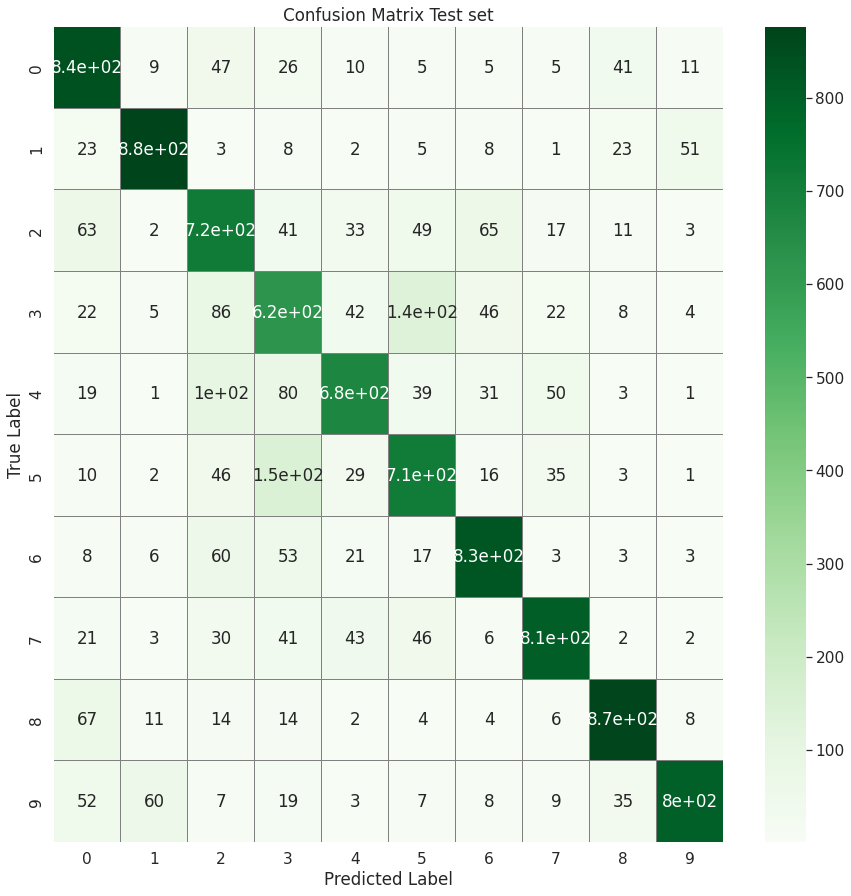

In [81]:
import seaborn as sns
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx_q1 = confusion_matrix(y_test2,y_pred1)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q1, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

In above figure the true predictions are shown on diameter. the other numbers show the false predictions. for example 52 data has label 9 but predicted in label 0

### Question 2

Now We add batchnormalization layers between layers. it has some benefits:
1) Convergence is faster  
2) it prevents from overfitting

In [82]:
model_q2 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [83]:
# compile the model
model_q2.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [84]:
# Now we should fit model on train data
history_q2 = model_q2.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 47s 28ms/step - loss: 1.3804 - accuracy: 0.5085 - val_loss: 1.0179 - val_accuracy: 0.6400
Epoch 2/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.8886 - accuracy: 0.6909 - val_loss: 0.8540 - val_accuracy: 0.7102
Epoch 3/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.6925 - accuracy: 0.7630 - val_loss: 0.7120 - val_accuracy: 0.7545
Epoch 4/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.5658 - accuracy: 0.8074 - val_loss: 0.6172 - val_accuracy: 0.7883
Epoch 5/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.4705 - accuracy: 0.8400 - val_loss: 0.6002 - val_accuracy: 0.8018
Epoch 6/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.3846 - accuracy: 0.8682 - val_loss: 0.5903 - val_accuracy: 0.8038
Epoch 7/25
1563/1563 [==============================] - 36s 23ms/step - loss: 0.3147 - accuracy: 0.8916 - val_loss: 0.5628 -

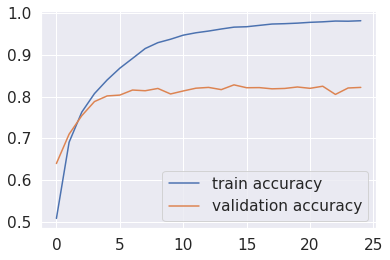

In [85]:
# Plot train and validation accuracy
plt.plot(history_q2.history['accuracy'], label='train accuracy')
plt.plot(history_q2.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

In [86]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q2, test_accuracy_q2 = model_q2.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 10ms/step - loss: 0.8320 - accuracy: 0.8222


In [87]:
# find y_pred and y_actuall for test data
pred2 = model_q2.predict(x_test2)
y_pred2 = np.argmax(pred2,axis=1)

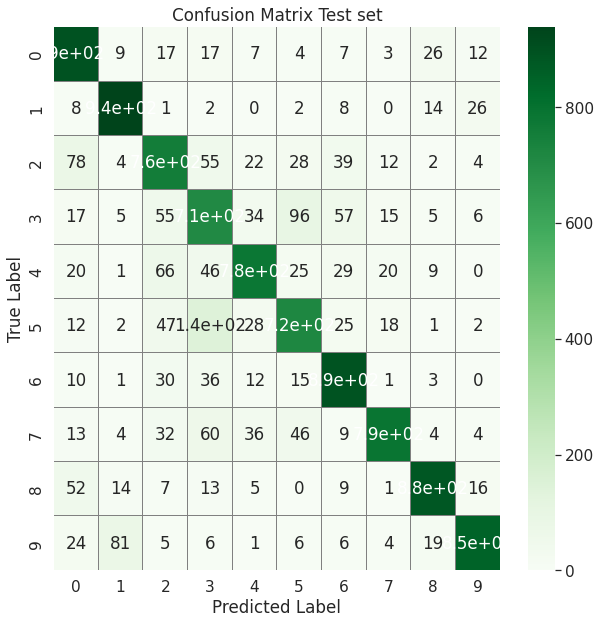

In [88]:
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx_q2 = confusion_matrix(y_test2,y_pred2)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q2, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

#### conclusion:
Our accuracy is increased and we have less overfitting than before but also we have a lot of difference between train and test accuracy

### Question 3

In [89]:
model_q3 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [90]:
model_q3.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [92]:
history_q3 = model_q3.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 39s 25ms/step - loss: 1.5333 - accuracy: 0.4356 - val_loss: 1.2198 - val_accuracy: 0.5661
Epoch 2/25
1563/1563 [==============================] - 37s 24ms/step - loss: 1.1444 - accuracy: 0.5961 - val_loss: 0.9619 - val_accuracy: 0.6591
Epoch 3/25
1563/1563 [==============================] - 37s 24ms/step - loss: 0.9388 - accuracy: 0.6777 - val_loss: 0.8420 - val_accuracy: 0.7093
Epoch 4/25
1563/1563 [==============================] - 37s 24ms/step - loss: 0.8154 - accuracy: 0.7213 - val_loss: 0.6736 - val_accuracy: 0.7653
Epoch 5/25
1563/1563 [==============================] - 37s 24ms/step - loss: 0.7253 - accuracy: 0.7546 - val_loss: 0.7727 - val_accuracy: 0.7458
Epoch 6/25
1563/1563 [==============================] - 37s 24ms/step - loss: 0.6611 - accuracy: 0.7780 - val_loss: 0.5996 - val_accuracy: 0.7961
Epoch 7/25
1563/1563 [==============================] - 37s 24ms/step - loss: 0.6051 - accuracy: 0.7967 - val_loss: 0.5477 -

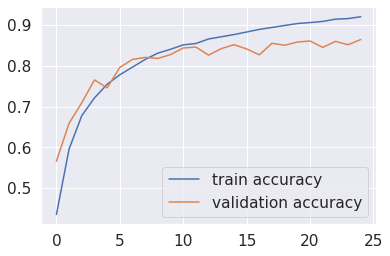

In [93]:
# Plot train and validation accuracy
plt.plot(history_q3.history['accuracy'], label='train accuracy')
plt.plot(history_q3.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

In [94]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q3, test_accuracy_q3 = model_q3.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 11ms/step - loss: 0.4588 - accuracy: 0.8644


In [95]:
# find y_pred and y_actuall for test data
pred3 = model_q3.predict(x_test2)
y_pred3 = np.argmax(pred3,axis=1)

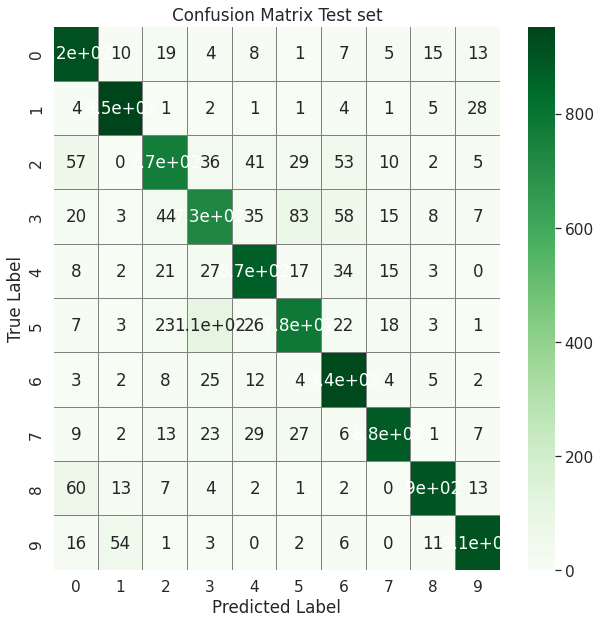

In [96]:
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx_q3 = confusion_matrix(y_test2,y_pred3)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q3, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

#### conclusion:
Our accuracy is increased and we have less overfitting than before. dropout delete some neurons randomly and the our model is goining to be less complicated

### Question 4

In this question we test 3 different optimizers. I choose SGD , RMSprop, Adagrad. also in last questions I used Adam optimizer. Here we can find differnces between these four optimizers

In [97]:
model_q4_1 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [98]:
model_q4_1.compile(optimizer='SGD', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [100]:
history_q4_1 = model_q4_1.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 39s 25ms/step - loss: 1.8366 - accuracy: 0.3296 - val_loss: 1.6048 - val_accuracy: 0.4087
Epoch 2/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5267 - accuracy: 0.4396 - val_loss: 1.3977 - val_accuracy: 0.4912
Epoch 3/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.3709 - accuracy: 0.5032 - val_loss: 1.2330 - val_accuracy: 0.5553
Epoch 4/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.2477 - accuracy: 0.5517 - val_loss: 1.2114 - val_accuracy: 0.5626
Epoch 5/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.1754 - accuracy: 0.5804 - val_loss: 1.0607 - val_accuracy: 0.6159
Epoch 6/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.1082 - accuracy: 0.6073 - val_loss: 1.0042 - val_accuracy: 0.6318
Epoch 7/25
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0523 - accuracy: 0.6267 - val_loss: 0.9467 -

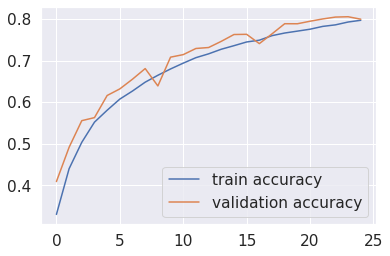

In [101]:
# Plot train and validation accuracy
plt.plot(history_q4_1.history['accuracy'], label='train accuracy')
plt.plot(history_q4_1.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

In [102]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q4_1, test_accuracy_q4_1 = model_q4_1.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 10ms/step - loss: 0.5968 - accuracy: 0.7996


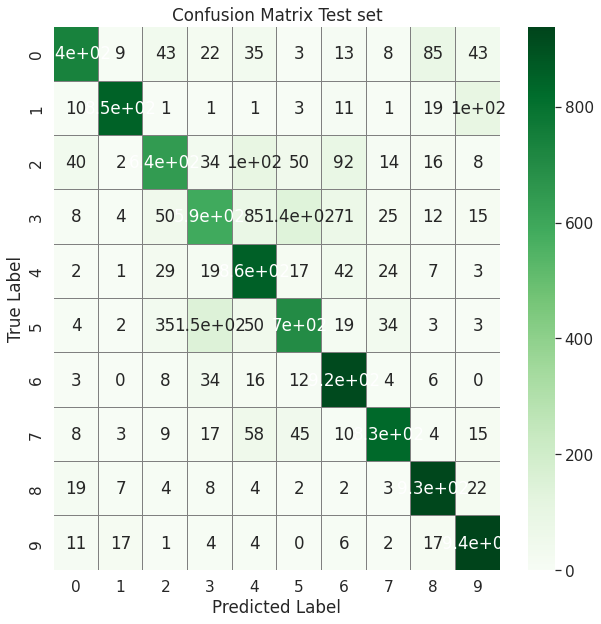

In [103]:
# find y_pred and y_actuall for test data
pred4_1 = model_q4_1.predict(x_test2)
y_pred4_1 = np.argmax(pred4_1,axis=1)
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx_q4_1 = confusion_matrix(y_test2,y_pred4_1)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q4_1, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

In [104]:
model_q4_2 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [105]:
model_q4_2.compile(optimizer='RMSprop', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [106]:
history_q4_2 = model_q4_2.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 68s 41ms/step - loss: 1.5286 - accuracy: 0.4487 - val_loss: 1.1194 - val_accuracy: 0.6028
Epoch 2/25
1563/1563 [==============================] - 66s 42ms/step - loss: 1.0217 - accuracy: 0.6463 - val_loss: 0.7894 - val_accuracy: 0.7280
Epoch 3/25
1563/1563 [==============================] - 66s 42ms/step - loss: 0.8311 - accuracy: 0.7171 - val_loss: 0.7099 - val_accuracy: 0.7554
Epoch 4/25
1563/1563 [==============================] - 67s 43ms/step - loss: 0.7228 - accuracy: 0.7576 - val_loss: 0.6279 - val_accuracy: 0.7862
Epoch 5/25
1563/1563 [==============================] - 66s 42ms/step - loss: 0.6589 - accuracy: 0.7803 - val_loss: 0.6293 - val_accuracy: 0.7912
Epoch 6/25
1563/1563 [==============================] - 66s 42ms/step - loss: 0.5994 - accuracy: 0.7998 - val_loss: 0.5441 - val_accuracy: 0.8153
Epoch 7/25
1563/1563 [==============================] - 67s 43ms/step - loss: 0.5593 - accuracy: 0.8136 - val_loss: 0.5475 -

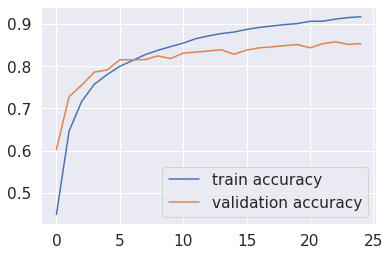

In [107]:
# Plot train and validation accuracy
plt.plot(history_q4_2.history['accuracy'], label='train accuracy')
plt.plot(history_q4_2.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

In [108]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q4_2, test_accuracy_q4_2 = model_q4_2.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 10ms/step - loss: 0.5145 - accuracy: 0.8537


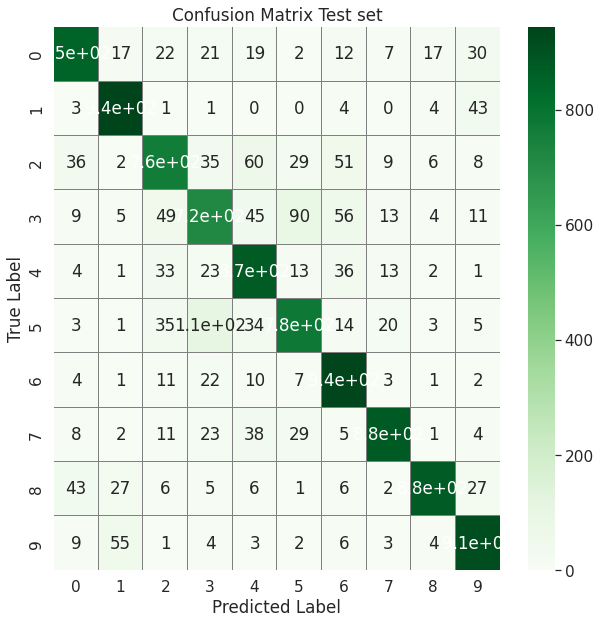

In [109]:
# find y_pred and y_actuall for test data
pred4_2 = model_q4_2.predict(x_test2)
y_pred4_2 = np.argmax(pred4_2,axis=1)
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(10, 10))
confusion_mtx_q4_2 = confusion_matrix(y_test2,y_pred4_2)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q4_2, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

In [110]:
model_q4_3 = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [111]:
model_q4_3.compile(optimizer='Adagrad', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [112]:
history_q4_3 = model_q4_3.fit(x_train2, y_train2, batch_size=32, epochs=25, validation_data=(x_test2, y_test2))

Epoch 1/25
1563/1563 [==============================] - 41s 25ms/step - loss: 2.4181 - accuracy: 0.1967 - val_loss: 2.0913 - val_accuracy: 0.2277
Epoch 2/25
1563/1563 [==============================] - 38s 25ms/step - loss: 2.1535 - accuracy: 0.2444 - val_loss: 1.9732 - val_accuracy: 0.2617
Epoch 3/25
1563/1563 [==============================] - 38s 24ms/step - loss: 2.0502 - accuracy: 0.2711 - val_loss: 1.9282 - val_accuracy: 0.2770
Epoch 4/25
1563/1563 [==============================] - 38s 24ms/step - loss: 1.9793 - accuracy: 0.2877 - val_loss: 1.8861 - val_accuracy: 0.2951
Epoch 5/25
1563/1563 [==============================] - 39s 25ms/step - loss: 1.9197 - accuracy: 0.3064 - val_loss: 1.8652 - val_accuracy: 0.3044
Epoch 6/25
1563/1563 [==============================] - 40s 25ms/step - loss: 1.8791 - accuracy: 0.3167 - val_loss: 1.8411 - val_accuracy: 0.3157
Epoch 7/25
1563/1563 [==============================] - 51s 33ms/step - loss: 1.8405 - accuracy: 0.3267 - val_loss: 1.7914 -

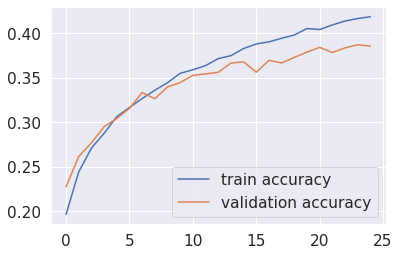

In [113]:
# Plot train and validation accuracy
plt.plot(history_q4_3.history['accuracy'], label='train accuracy')
plt.plot(history_q4_3.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='lower right')

In [114]:
# now we can evaluate model by giving test data to it and measure loss and accuracy
test_loss_q4_3, test_accuracy_q4_3 = model_q4_3.evaluate(x_test2, y_test2)

313/313 [==============================] - 3s 10ms/step - loss: 1.6882 - accuracy: 0.3856


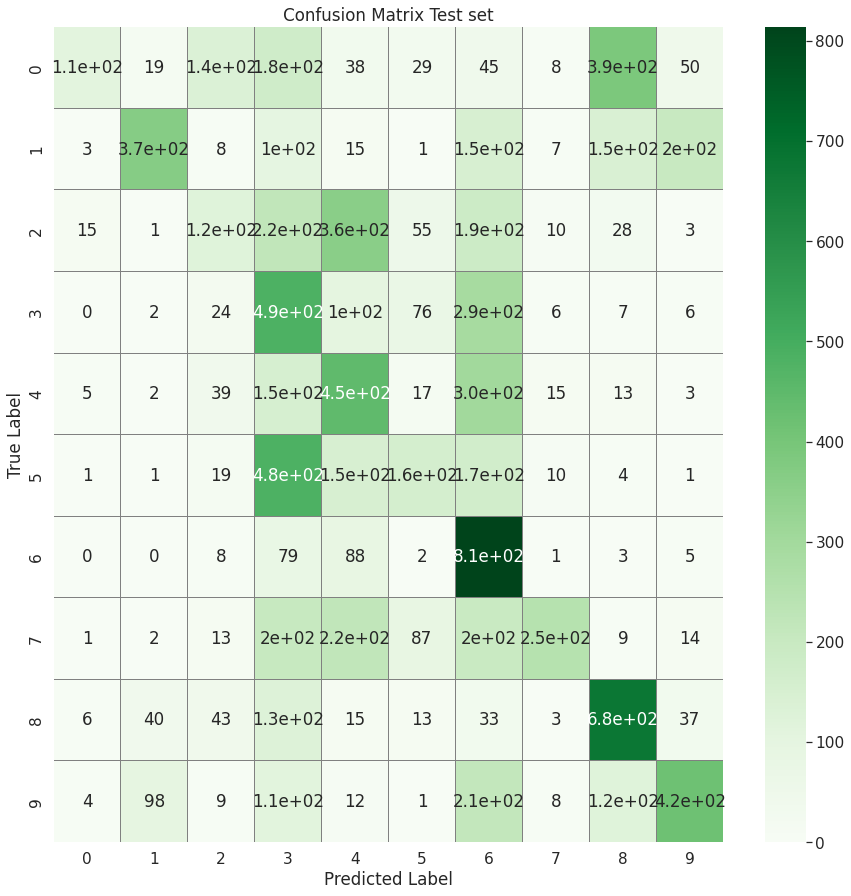

In [116]:
# find y_pred and y_actuall for test data
pred4_3 = model_q4_3.predict(x_test2)
y_pred4_3 = np.argmax(pred4_3,axis=1)
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx_q4_3 = confusion_matrix(y_test2,y_pred4_3)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_q4_3, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

#### conclusion:
Now we can compare SGD , RMSprop, Adagrad and Adam  
- According to time, Adam is faster than others  
- According to accuracy of test data Adam and RMSprop are good  
- According to speed of convergence, Adam and RMSprop are good  
finally we can choose Adam optimizer

### Question 5

According to last questions, we can say model_q3 is the best model. so we can work with that in this question.

In [117]:
# We can show f1 and Recall and precision with this tool:
print(classification_report(y_test2,y_pred3))

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      1000
           1       0.91      0.95      0.93      1000
           2       0.85      0.77      0.81      1000
           3       0.75      0.73      0.74      1000
           4       0.85      0.87      0.86      1000
           5       0.83      0.78      0.80      1000
           6       0.83      0.94      0.88      1000
           7       0.93      0.88      0.91      1000
           8       0.94      0.90      0.92      1000
           9       0.92      0.91      0.91      1000

    accuracy                           0.86     10000
   macro avg       0.87      0.86      0.86     10000
weighted avg       0.87      0.86      0.86     10000



According to explanation in pdf file and the formula for recall and f1 and precision we can say this Optimizer is good. f1 is contain precision and recall inside it and for every 10 class has a good value. class 3 has less precision and other metrics. mabe this the data of this class for training doesn`t have good quality and noisy data in this class is a lot. 

# Section 2

### Question2

In [124]:
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from matplotlib import pyplot

#### Original image

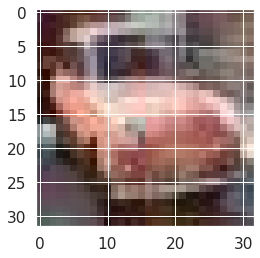

In [125]:
# first We load one image from dataset
img = load_img('./CIFAR10/train/automobile/0008.jpg')
plt.imshow(img)
plt.show()

#### 1) Horizontal and Vertical Shift Augmentation

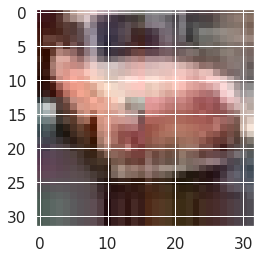

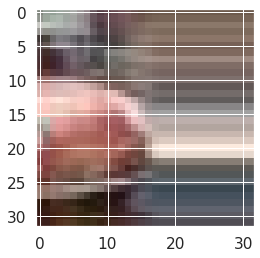

In [126]:
### Vertical
# convert to numpy array
data = img_to_array(img)
# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen1_1 = ImageDataGenerator(height_shift_range=0.5)
# prepare iterator
it1_1 = datagen1_1.flow(samples, batch_size=1)
# generate batch of images
batch1_1 = it1_1.next()
# convert to unsigned integers for viewing
image1 = batch1_1[0].astype('uint8')
plt.imshow(image1)
plt.show()

### Horizontal
datagen1_2 = ImageDataGenerator(width_shift_range=0.6)
it1_2 = datagen1_2.flow(samples, batch_size=1)
batch1_2 = it1_2.next()
image2 = batch1_2[0].astype('uint8')
plt.imshow(image2)
plt.show()




#### 2)Horizontal and Vertical Flip Augmentation

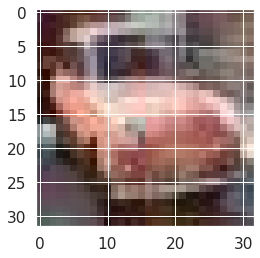

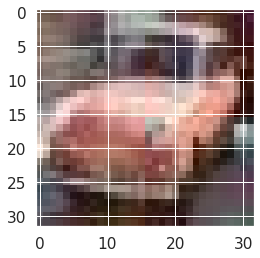

In [127]:
### Vertical
datagen2_1 = ImageDataGenerator(vertical_flip=True)
it2_1 = datagen2_1.flow(samples, batch_size=1)
batch2_1 = it2_1.next()
image3 = batch2_1[0].astype('uint8')
plt.imshow(image3)
plt.show()
### Horizontal
datagen2_2 = ImageDataGenerator(horizontal_flip=True)
it2_2 = datagen2_2.flow(samples, batch_size=1)
batch2_2 = it2_2.next()
image4 = batch2_2[0].astype('uint8')
plt.imshow(image4)
plt.show()


#### 3) Random Rotation Augmentation

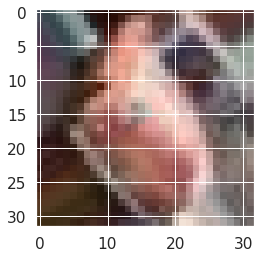

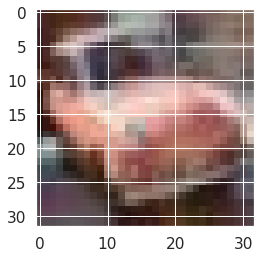

In [128]:
datagen3_1 = ImageDataGenerator(rotation_range=90)
it3_1 = datagen3_1.flow(samples, batch_size=1)
batch3_1 = it3_1.next()
image5 = batch3_1[0].astype('uint8')
plt.imshow(image5)
plt.show()

it3_2 = datagen3_1.flow(samples, batch_size=1)
batch3_2 = it3_2.next()
image6 = batch3_2[0].astype('uint8')
plt.imshow(image6)
plt.show()

#### 4) Random Brightness Augmentation

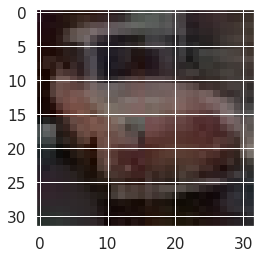

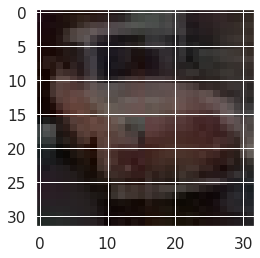

In [129]:
datagen4_1 = ImageDataGenerator(brightness_range=[0.2,1.0])
it4_1 = datagen4_1.flow(samples, batch_size=1)
batch4_1 = it4_1.next()
image7 = batch4_1[0].astype('uint8')
plt.imshow(image7)
plt.show()

it4_2 = datagen4_1.flow(samples, batch_size=1)
batch4_2 = it4_2.next()
image8 = batch4_2[0].astype('uint8')
plt.imshow(image8)
plt.show()

#### 5) Random Zoom Augmentation

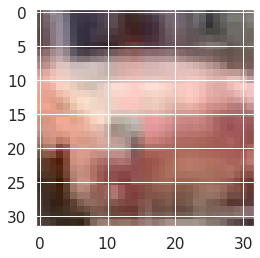

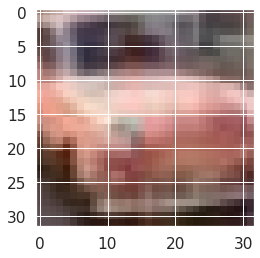

In [130]:
datagen5_1 = ImageDataGenerator(zoom_range=[0.5,1.0])
it5_1 = datagen5_1.flow(samples, batch_size=1)
batch5_1 = it5_1.next()
image9 = batch5_1[0].astype('uint8')
plt.imshow(image9)
plt.show()

it5_2 = datagen5_1.flow(samples, batch_size=1)
batch5_2 = it5_2.next()
image10 = batch5_2[0].astype('uint8')
plt.imshow(image10)
plt.show()

### Question 3

In [132]:
# Delete 90 percentage of cat and dog
x_train_new = []
y_train_new = []
cat_counter = 0
dog_counter = 0
for x,y in zip(x_train2, y_train2):
    if (y.astype(int)[0] == 3 and cat_counter==500) or (y.astype(int)[0] == 5 and dog_counter==500):
        continue
    elif y.astype(int)[0] == 3 :
        x_train_new.append(x)
        y_train_new.append(y)
        cat_counter += 1
    elif y.astype(int)[0] == 5 :
        x_train_new.append(x)
        y_train_new.append(y)
        dog_counter += 1
    else:
        x_train_new.append(x)
        y_train_new.append(y)
        
x_train2_new=np.array(x_train_new)
y_train2_new=np.array(y_train_new)

In [133]:
y_train2_new.shape

(41000, 1)

In [134]:
# train with best model of section1
best_model = keras.Sequential([
                          
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu', input_shape=(32, 32, 3)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), padding='same', kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(128, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    layers.Dense(64, kernel_initializer='he_uniform', activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(10, kernel_initializer='he_uniform', activation='softmax')

])

In [135]:
best_model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [137]:
history_best = best_model.fit(x_train2_new, y_train2_new, batch_size=32, epochs=20, validation_data=(x_test2, y_test2))

Epoch 1/20
1282/1282 [==============================] - 42s 33ms/step - loss: 1.0168 - accuracy: 0.6512 - val_loss: 1.2577 - val_accuracy: 0.5964
Epoch 2/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.8123 - accuracy: 0.7264 - val_loss: 1.0969 - val_accuracy: 0.6596
Epoch 3/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.6937 - accuracy: 0.7703 - val_loss: 0.9240 - val_accuracy: 0.7038
Epoch 4/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.6230 - accuracy: 0.7944 - val_loss: 0.8743 - val_accuracy: 0.7209
Epoch 5/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.5564 - accuracy: 0.8171 - val_loss: 0.8212 - val_accuracy: 0.7267
Epoch 6/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.5167 - accuracy: 0.8310 - val_loss: 0.8757 - val_accuracy: 0.7243
Epoch 7/20
1282/1282 [==============================] - 37s 29ms/step - loss: 0.4690 - accuracy: 0.8465 - val_loss: 0.8180 -

In [138]:
# find y_pred and y_actuall for test data
pred_best = best_model.predict(x_test2)
y_pred_best = np.argmax(pred_best,axis=1)

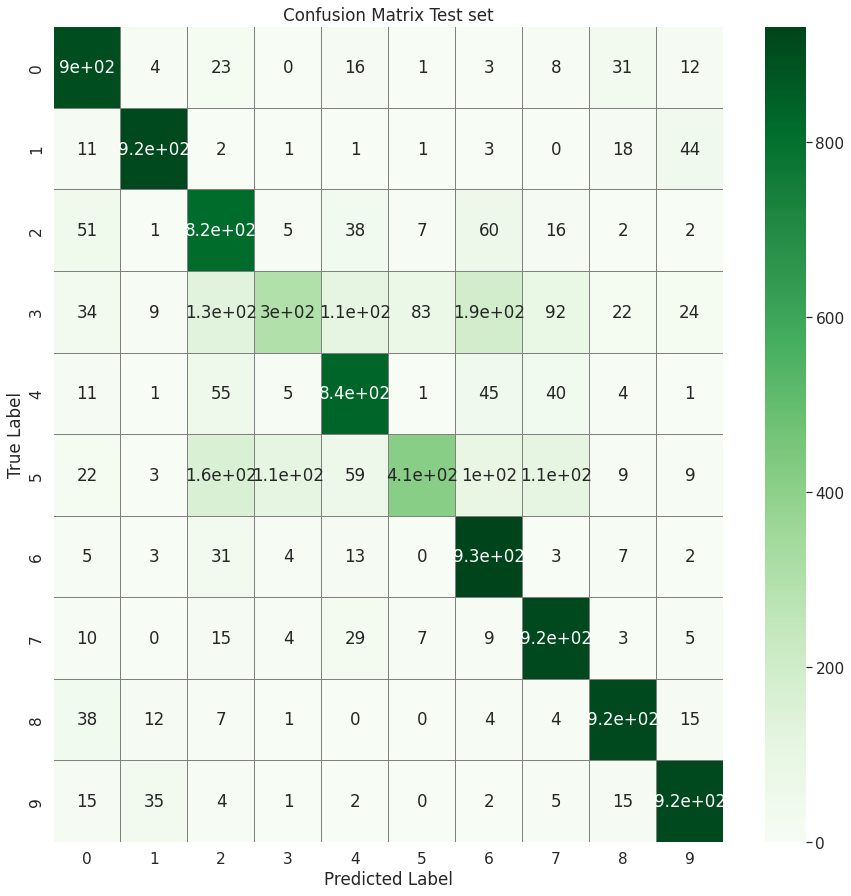

In [140]:
# show confusion matrix on test data
f,ax = plt.subplots(figsize=(15, 15))
confusion_mtx_best = confusion_matrix(y_test2,y_pred_best)
sns.set(font_scale=1.4)
sns.heatmap(confusion_mtx_best, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray",ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Test set")
plt.show()

The accuracy is decreased and in classes that we delete the data(dog and cat) train isn`t done well. so if we cant predict dog and cat very good. In confusion matrix is also we can see this probelm.The values on major diameter in class 3 and 5 are decreases and increases the error. if we print metrics like precision it would show us that f1 and recall is decreases in those classes

In [141]:
print(classification_report(y_test2,y_pred_best))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1000
           1       0.93      0.92      0.93      1000
           2       0.65      0.82      0.73      1000
           3       0.70      0.30      0.42      1000
           4       0.76      0.84      0.80      1000
           5       0.81      0.41      0.55      1000
           6       0.69      0.93      0.79      1000
           7       0.77      0.92      0.84      1000
           8       0.89      0.92      0.91      1000
           9       0.89      0.92      0.91      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.77     10000
weighted avg       0.79      0.79      0.77     10000

